# Fitbit Jupyter Notebook

## Step 1: Analyse the data

In [1]:
%pip install pandas matplotlib seaborn networkx scikit-learn imbalanced-learn

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For handling imbalanced data

In [3]:
# Define the path and get all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
# List to store data from all CSVs
dfs = []

# Read all CSV files
for file in files:
    df = pd.read_csv(file)

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Keep only weekdays (Monday to Friday)
    df = df[df['date'].dt.weekday < 5]

    # Keep only records before 18:00
    df = df[df['date'].dt.hour < 18]

    # Append the cleaned data
    dfs.append(df)

In [5]:
# Concatenate all data
df = pd.concat(dfs, ignore_index=True)

### Plot 1: Analyze activity by persons

In [6]:
# Function to plot data for a single person
def plot_person_data(treatment_id, df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Activity Data for Person {treatment_id}')

    # Steps over time
    axes[0, 0].plot(df['date'], df['steps'], marker='o', linestyle='-', label='Steps')
    axes[0, 0].set_title('Steps Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Steps')
    axes[0, 0].legend()

    # Calories over time
    axes[0, 1].plot(df['date'], df['calories'], marker='o', linestyle='-', color='r', label='Calories')
    axes[0, 1].set_title('Calories Burned Over Time')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Calories')
    axes[0, 1].legend()

    # Distance over time
    axes[1, 0].plot(df['date'], df['distance'], marker='o', linestyle='-', color='g', label='Distance')
    axes[1, 0].set_title('Distance Over Time')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Distance (km)')
    axes[1, 0].legend()

    # METs over time
    axes[1, 1].plot(df['date'], df['mets'], marker='o', linestyle='-', color='purple', label='METs')
    axes[1, 1].set_title('METs Over Time')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('METs')
    axes[1, 1].legend()

    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

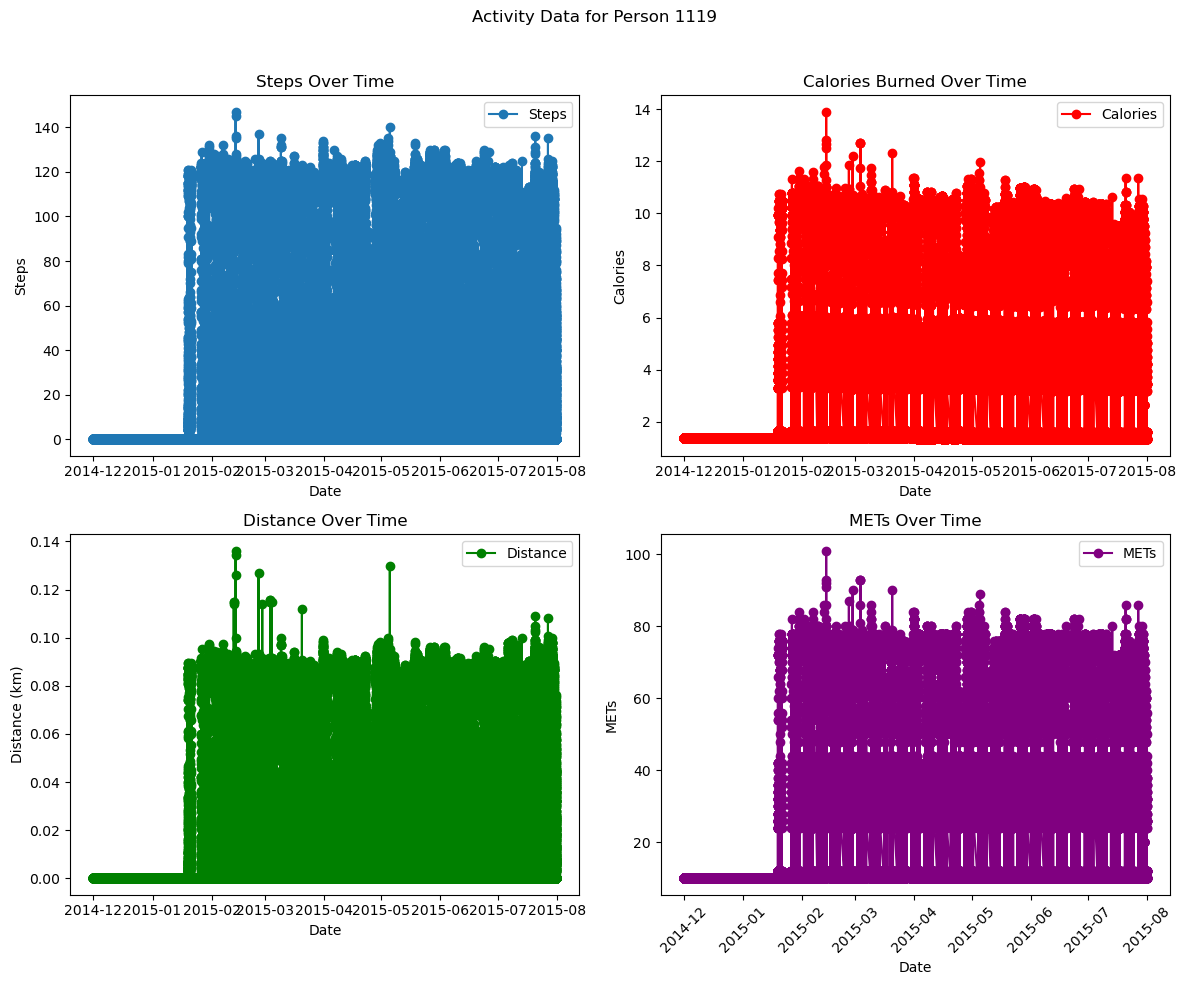

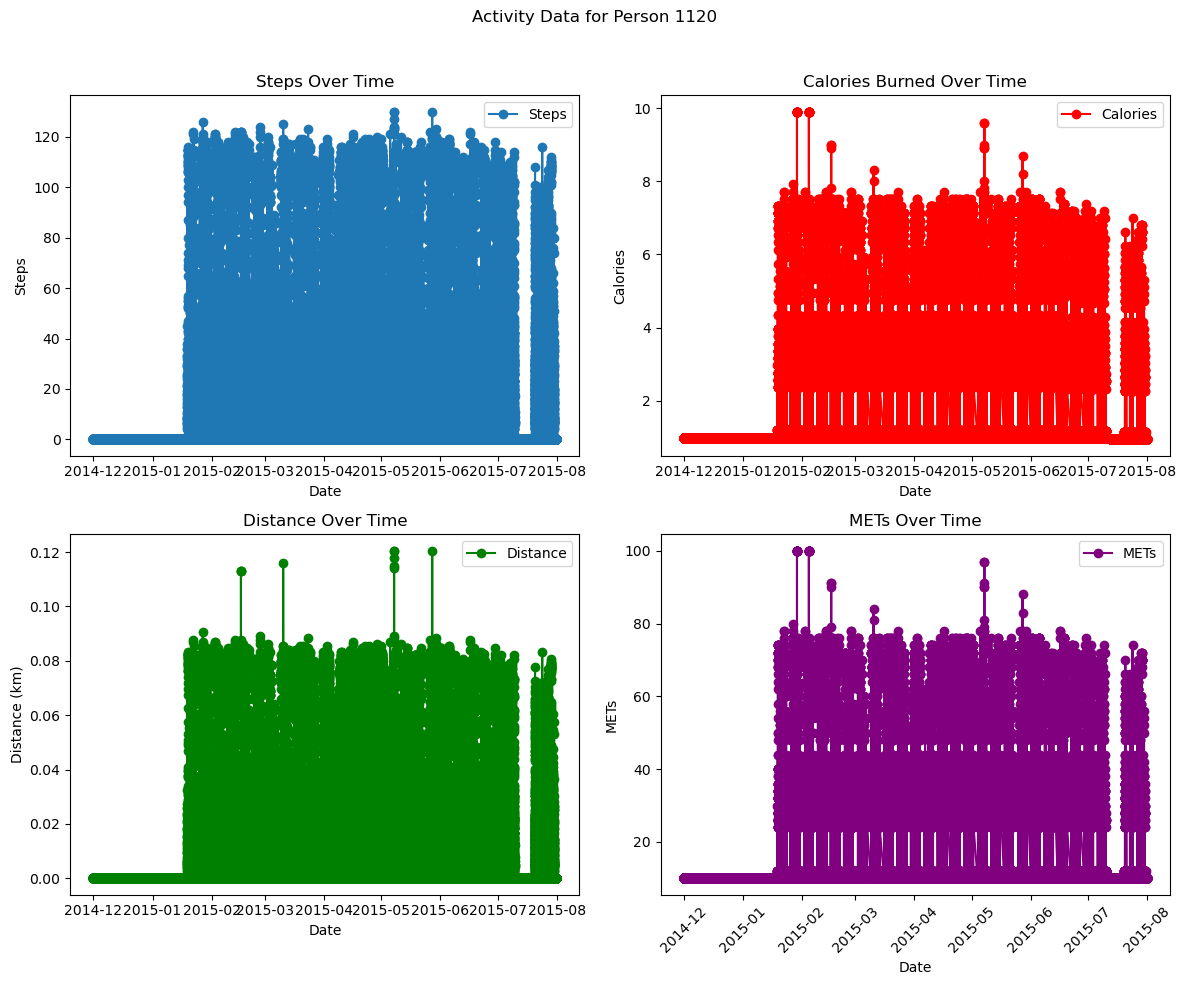

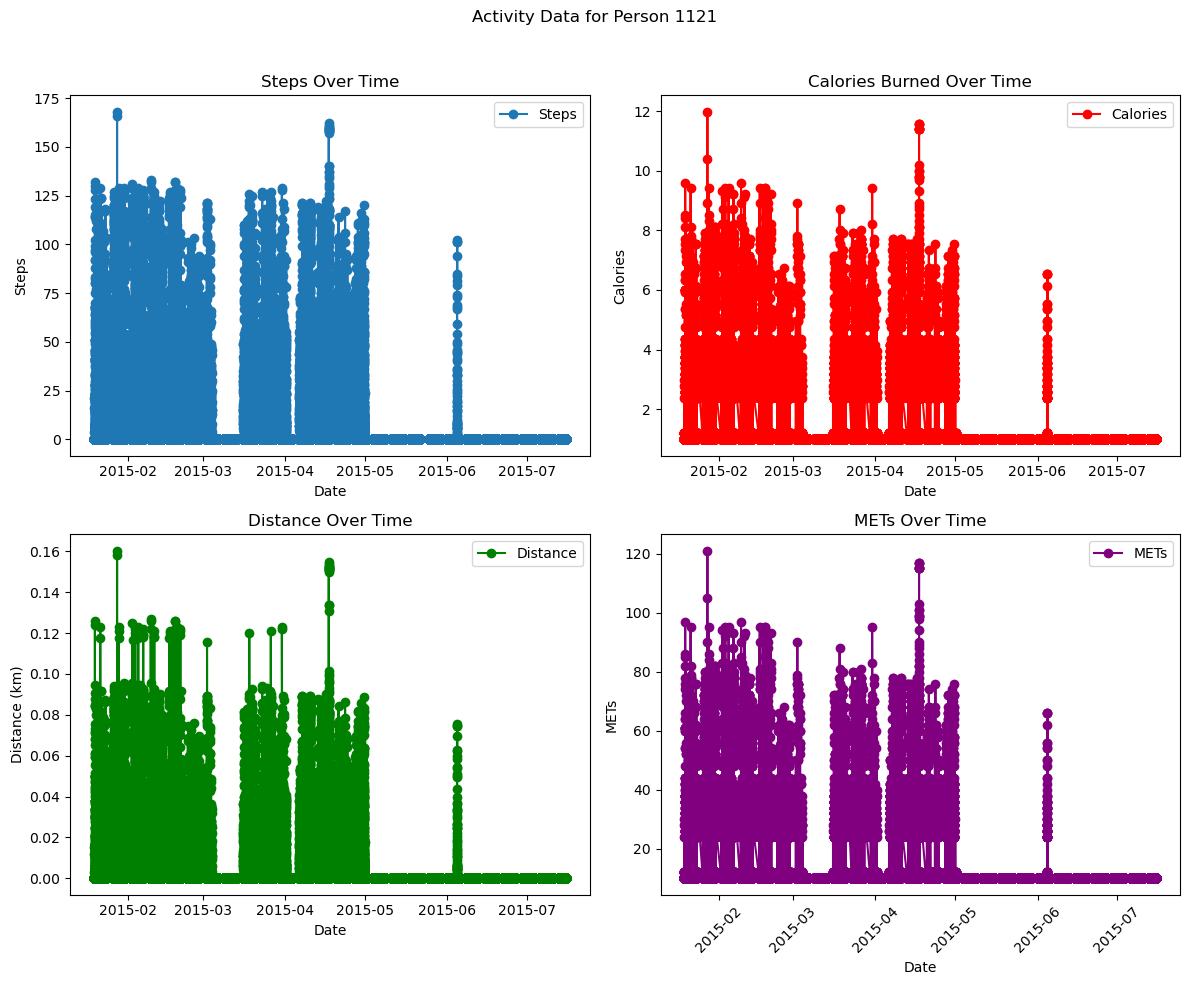

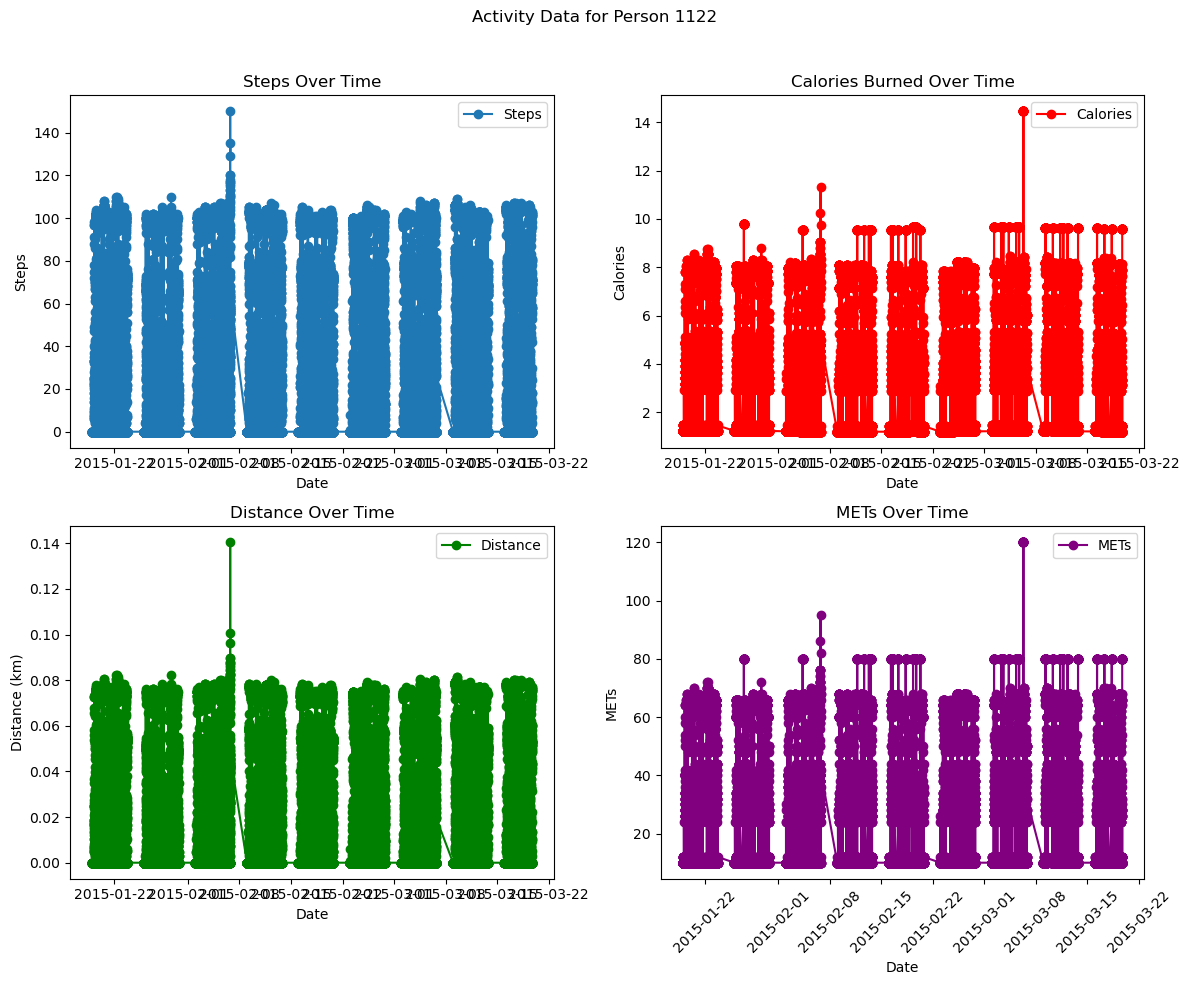

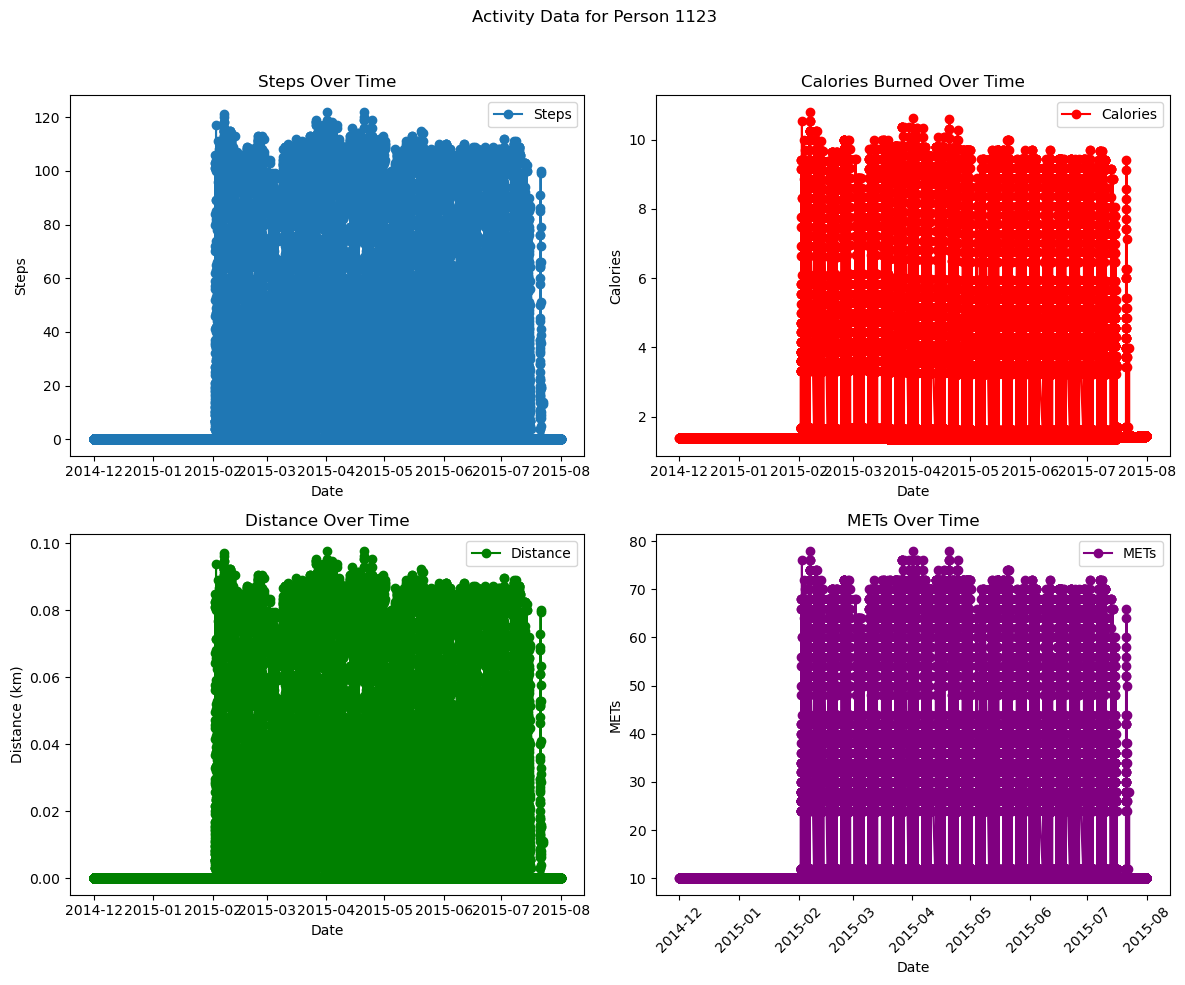

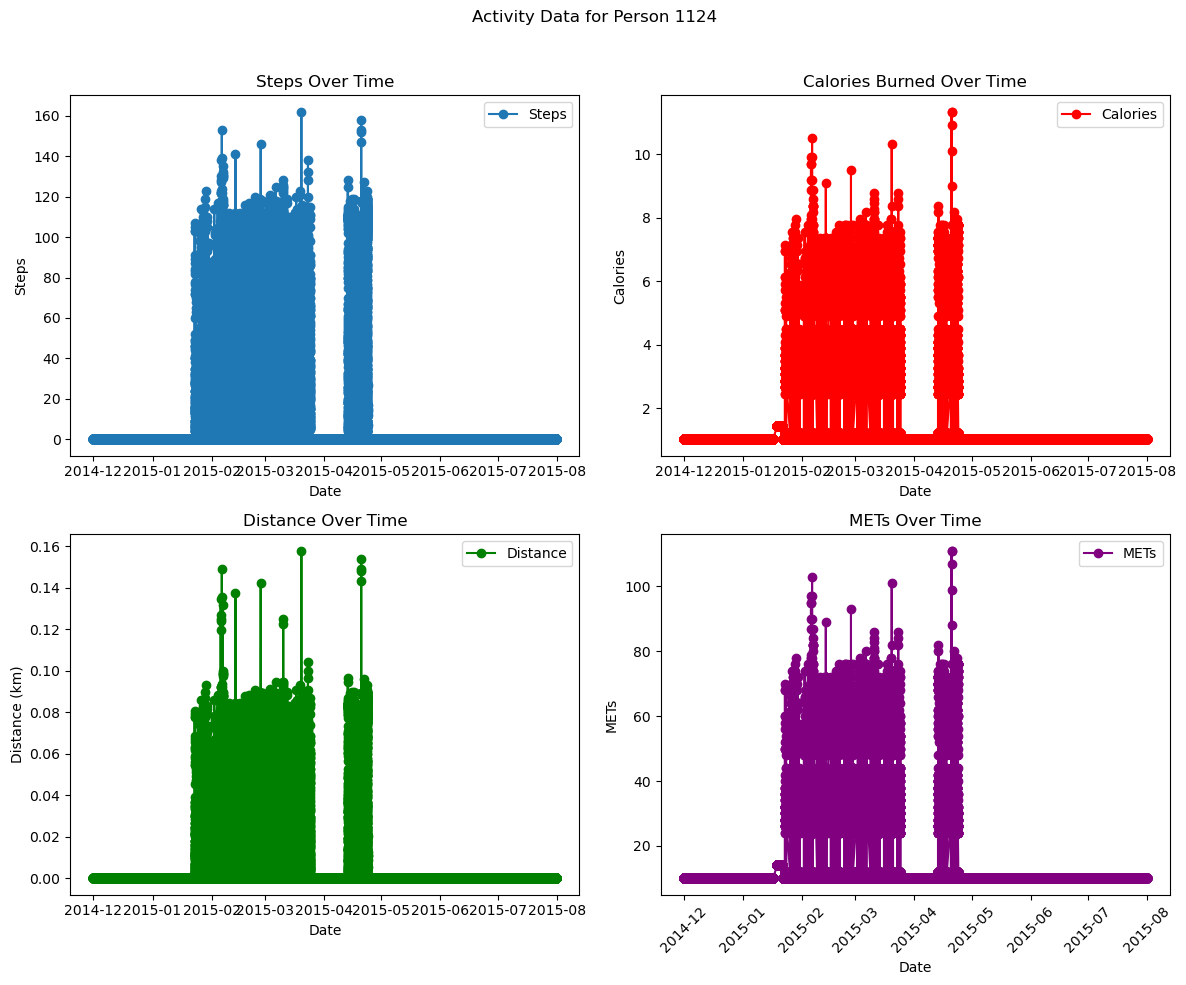

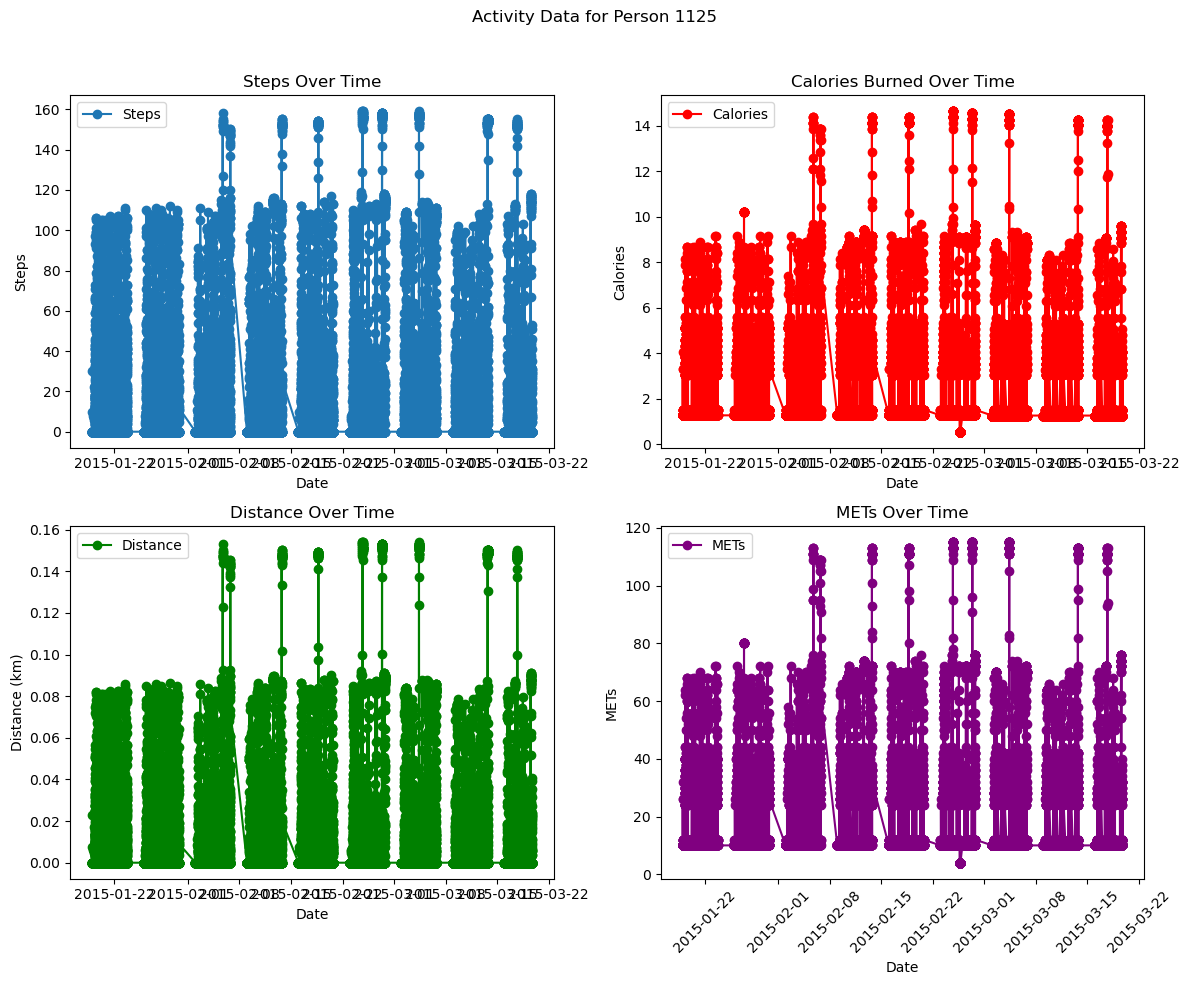

In [7]:
# Group by treatment_id and plot each person's data
for treatment_id, person_df in df.groupby("treatment_id"):
    plot_person_data(treatment_id, person_df)

### Plot 2: Comparison of Activity across individuals

In [8]:
# Aggregated Data Analysis
def plot_group_comparison(df):
    df_summary = df.groupby("treatment_id").agg({
        "steps": "mean",
        "calories": "mean",
        "distance": "mean",
        "mets": "mean"
    }).rename(columns={
        "steps": "Avg Steps",
        "calories": "Avg Calories",
        "distance": "Avg Distance",
        "mets": "Avg METs"
    })

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Comparison of Activity Metrics Across Individuals")

    df_summary["Avg Steps"].plot(kind="bar", ax=axes[0, 0], color="blue")
    axes[0, 0].set_title("Average Steps")
    axes[0, 0].set_ylabel("Steps")

    df_summary["Avg Calories"].plot(kind="bar", ax=axes[0, 1], color="red")
    axes[0, 1].set_title("Average Calories")
    axes[0, 1].set_ylabel("Calories")

    df_summary["Avg Distance"].plot(kind="bar", ax=axes[1, 0], color="green")
    axes[1, 0].set_title("Average Distance")
    axes[1, 0].set_ylabel("Distance (km)")

    df_summary["Avg METs"].plot(kind="bar", ax=axes[1, 1], color="purple")
    axes[1, 1].set_title("Average METs")
    axes[1, 1].set_ylabel("METs")

    for ax in axes.flat:
        ax.set_xlabel("Person ID")
        ax.set_xticklabels(df_summary.index, rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

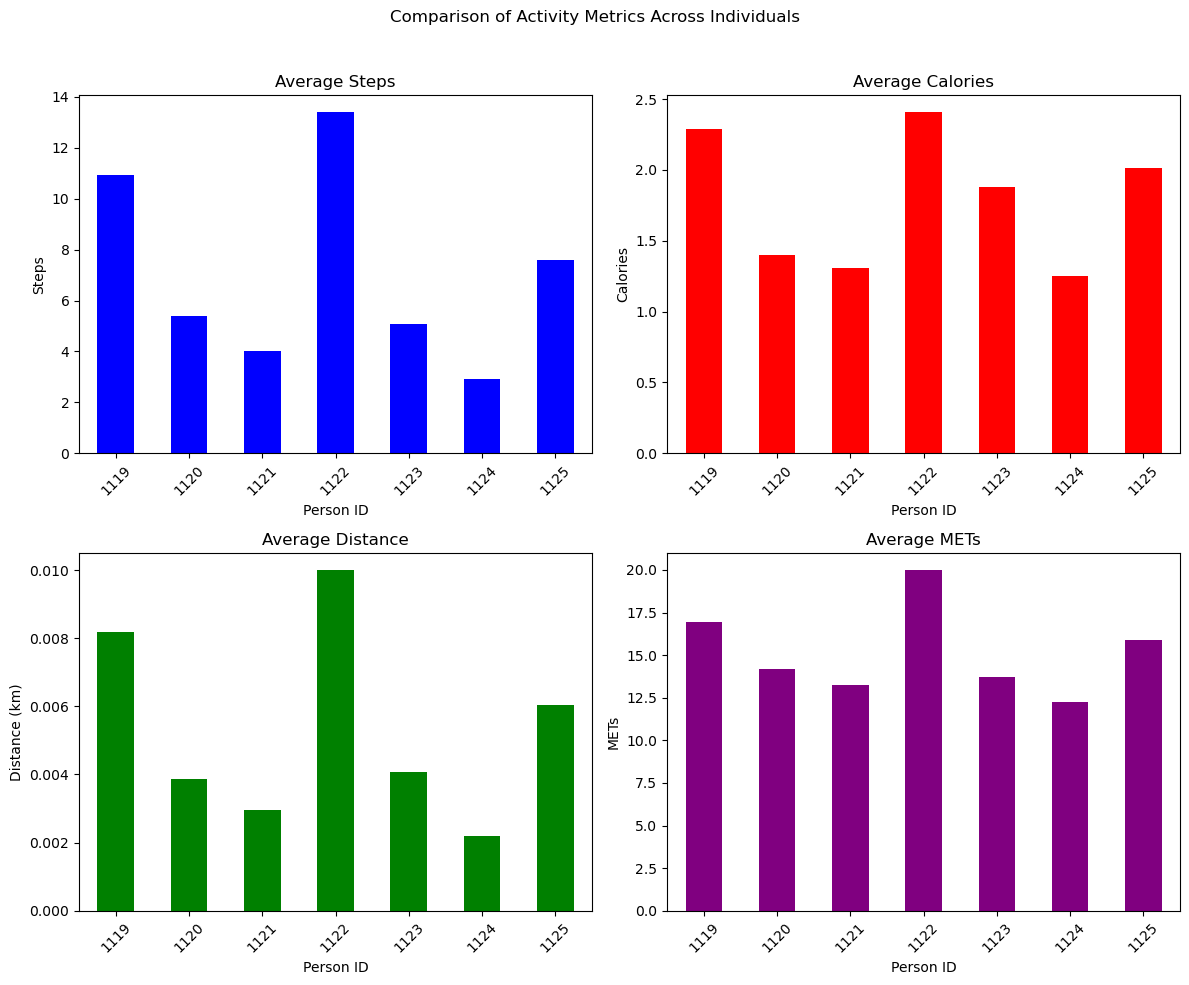

In [9]:
plot_group_comparison(df)

### Plot 3: Individual means

In [10]:
# Compute individual means for steps
individual_means = df.groupby(['treatment_id', df['date'].dt.date])['steps'].mean().reset_index()

In [11]:
# Convert 'date' back to datetime format
individual_means['date'] = pd.to_datetime(individual_means['date'])

In [12]:
treatment_ids = individual_means['treatment_id'].unique()

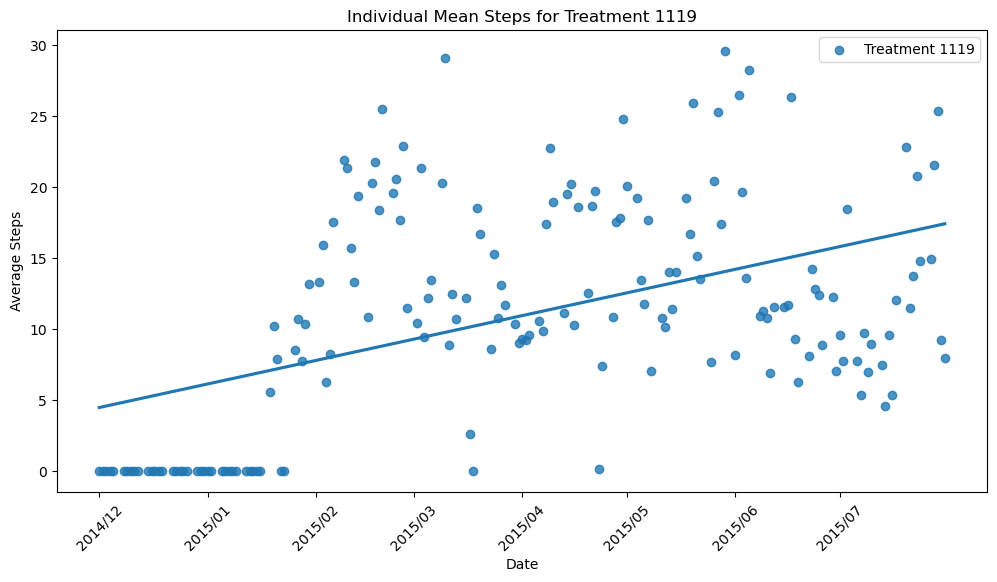

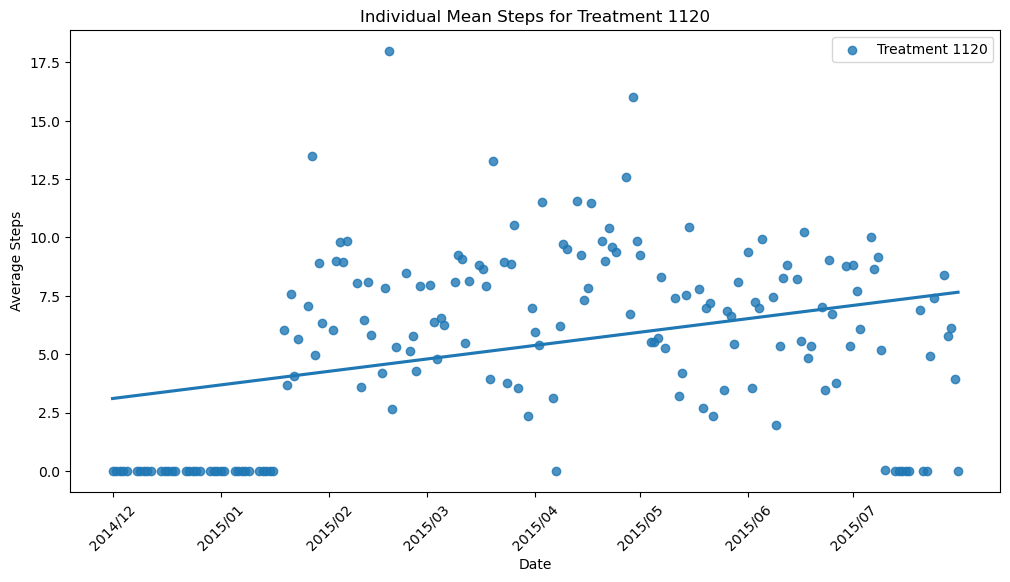

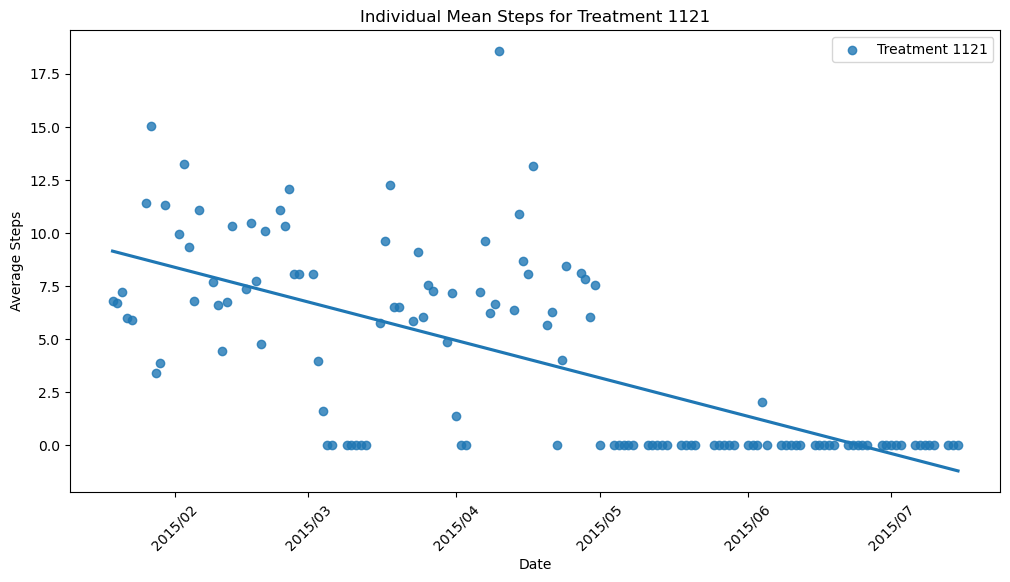

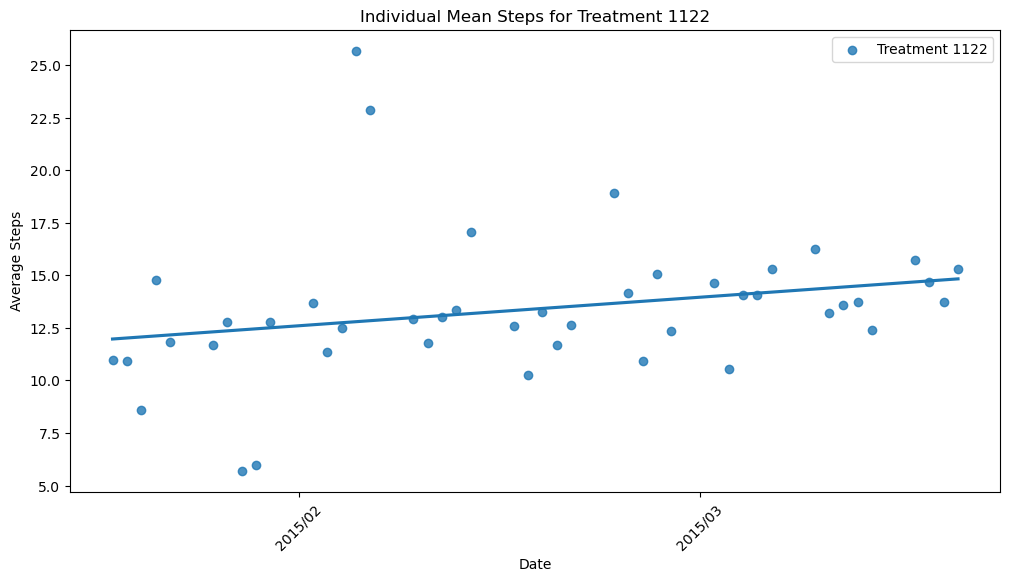

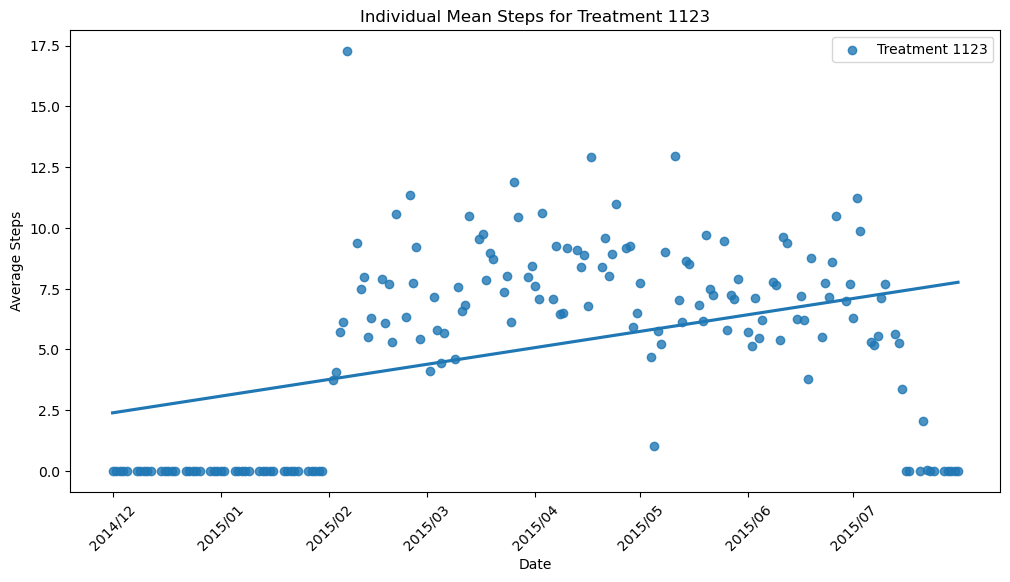

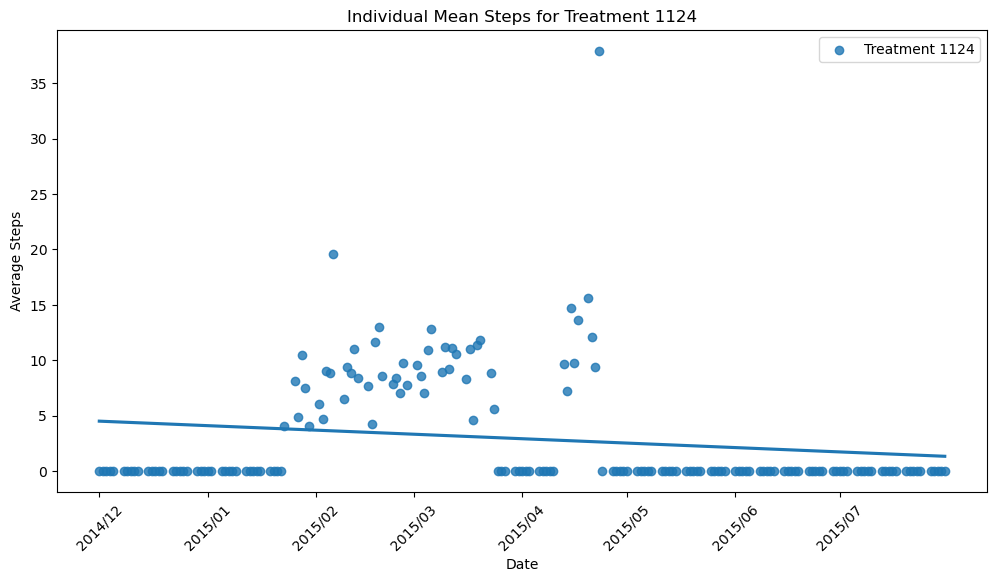

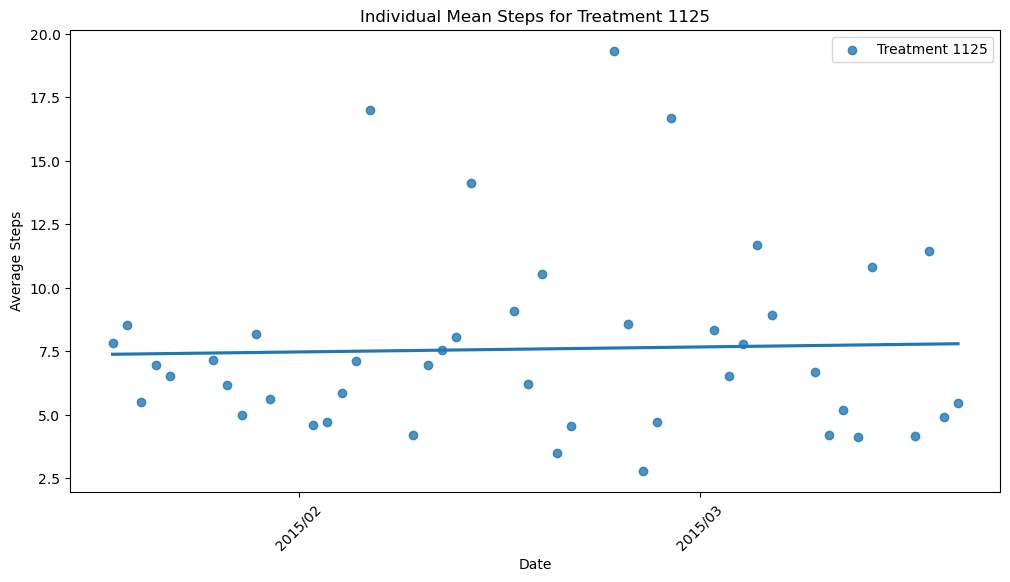

In [13]:
for treatment in treatment_ids:
    plt.figure(figsize=(12, 6))

    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()  # Use .copy() here

    # Convert 'date' to numeric for regression (safe modification)
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days

    # Plot regression for this individual
    sns.regplot(data=subset, x='date_numeric', y='steps', scatter=True, ci=None, label=f'Treatment {treatment}')

    # Set the x-ticks to the first day of each month (same as Plot 2)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')  # First day of each month
    month_numeric = (months - subset['date'].min()).days  # Convert the months to numeric

    # Apply the same x-tick formatting as in Plot 2 (YYYY/MM format)
    plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability

    # Formatting
    plt.title(f"Individual Mean Steps for Treatment {treatment}")
    plt.xlabel("Date")
    plt.ylabel("Average Steps")
    plt.legend()
    plt.show()

### Plot 4: Average steps

In [14]:
# Compute the average of all individuals' steps per day
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

In [15]:
# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

In [16]:
# Calculate and print the average number of steps
overall_avg_steps = average_steps['steps'].mean()
print(f"Average number of steps: {overall_avg_steps:.2f} by minute")
print(f"Average number of steps: {overall_avg_steps * 60:.2f} by hour")
print(f"Average number of steps: {overall_avg_steps * 60 * 24:.2f} by day")

Average number of steps: 5.67 by minute
Average number of steps: 340.37 by hour
Average number of steps: 8168.95 by day


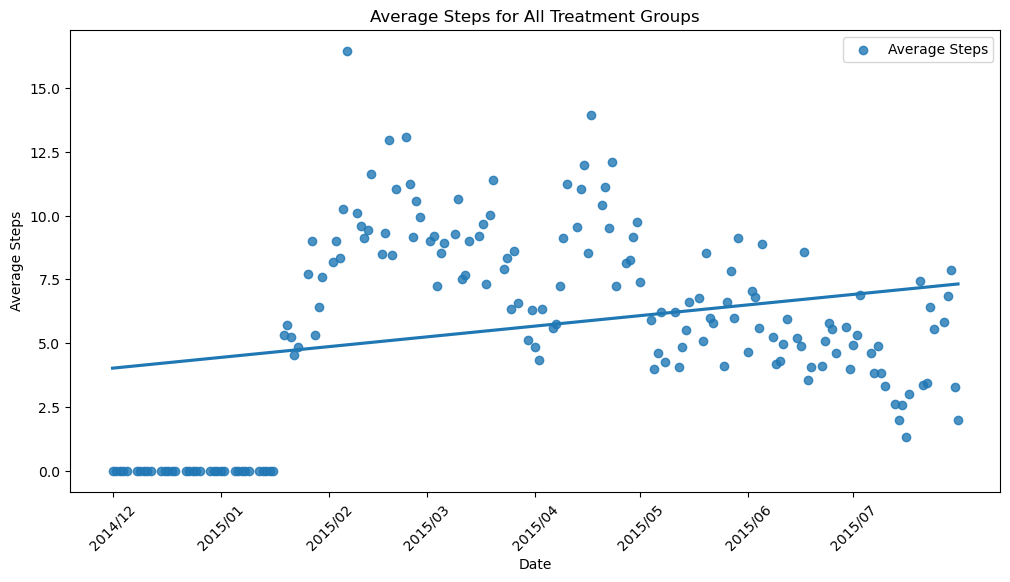

In [17]:
# Plot the average steps for all treatment_ids
plt.figure(figsize=(12, 6))

# Convert 'date' to numeric for regression (safe modification)
average_steps['date_numeric'] = (average_steps['date'] - average_steps['date'].min()).dt.days

# Plot the regression for the average steps
sns.regplot(data=average_steps, x='date_numeric', y='steps', scatter=True, ci=None, label='Average Steps')

# Set the x-ticks to the first day of each month (same as Plot 1)
months = pd.date_range(start=average_steps['date'].min(), end=average_steps['date'].max(), freq='MS')  # First day of each month
month_numeric = (months - average_steps['date'].min()).days  # Convert the months to numeric

# Apply the same x-tick formatting as in Plot 1 (YYYY/MM format)
plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability

# Formatting
plt.title("Average Steps for All Treatment Groups")
plt.xlabel("Date")
plt.ylabel("Average Steps")
plt.legend()
plt.show()

### Plot 5: Individual plots with average steps superposed

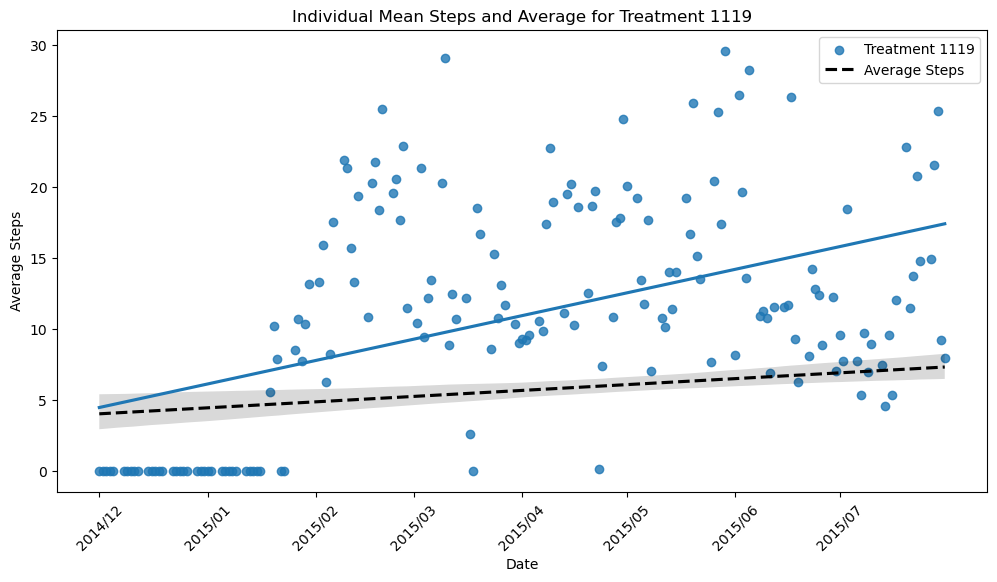

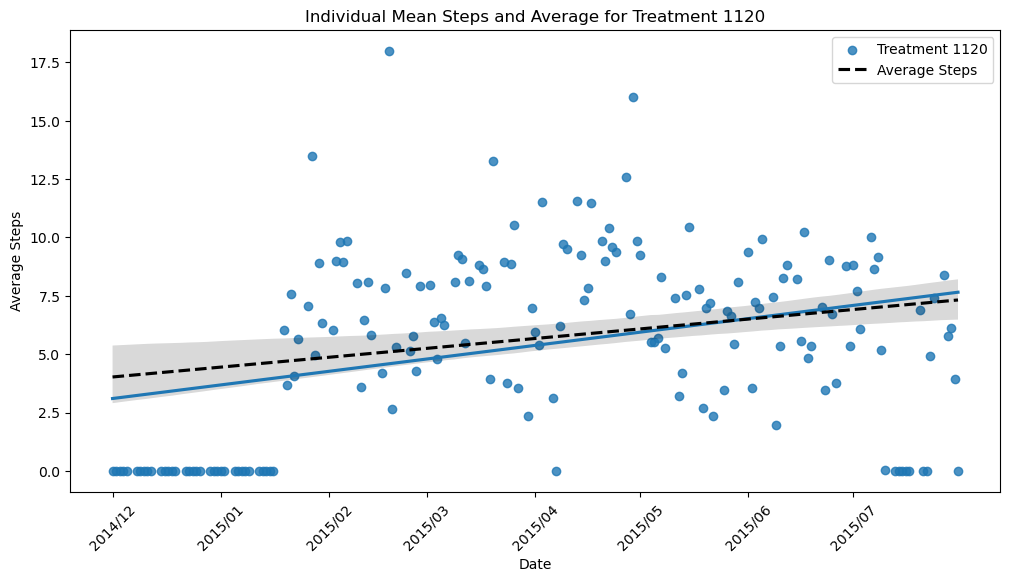

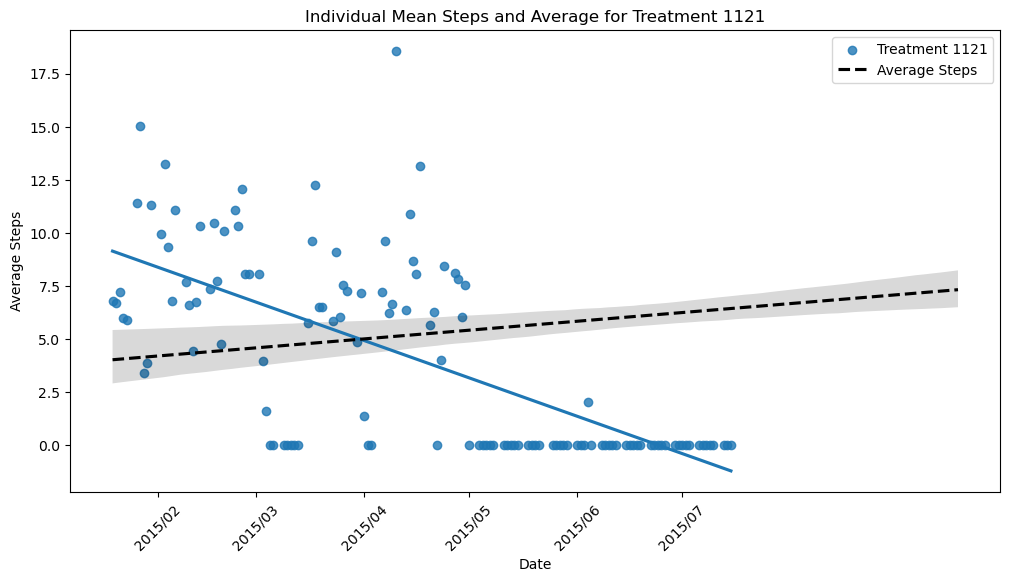

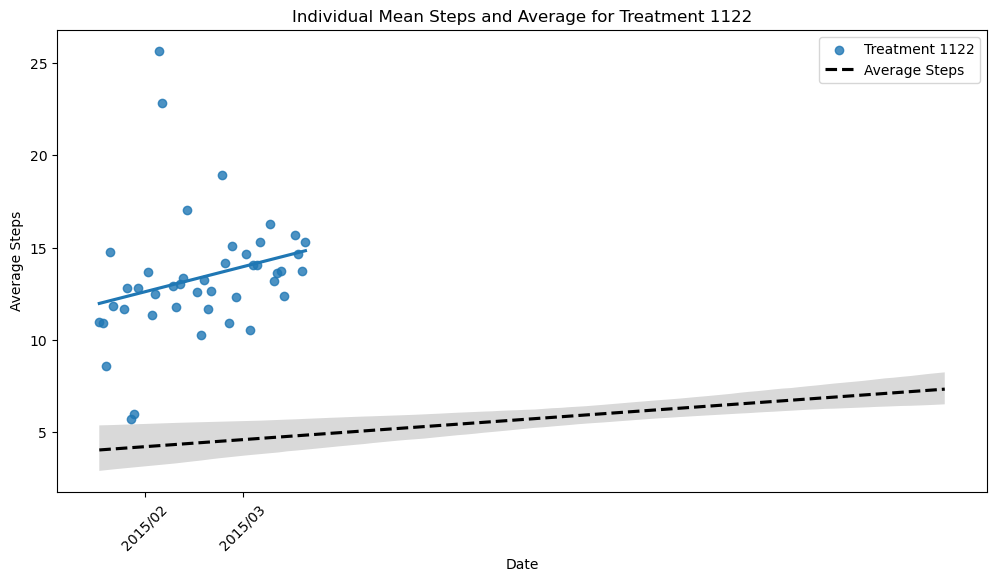

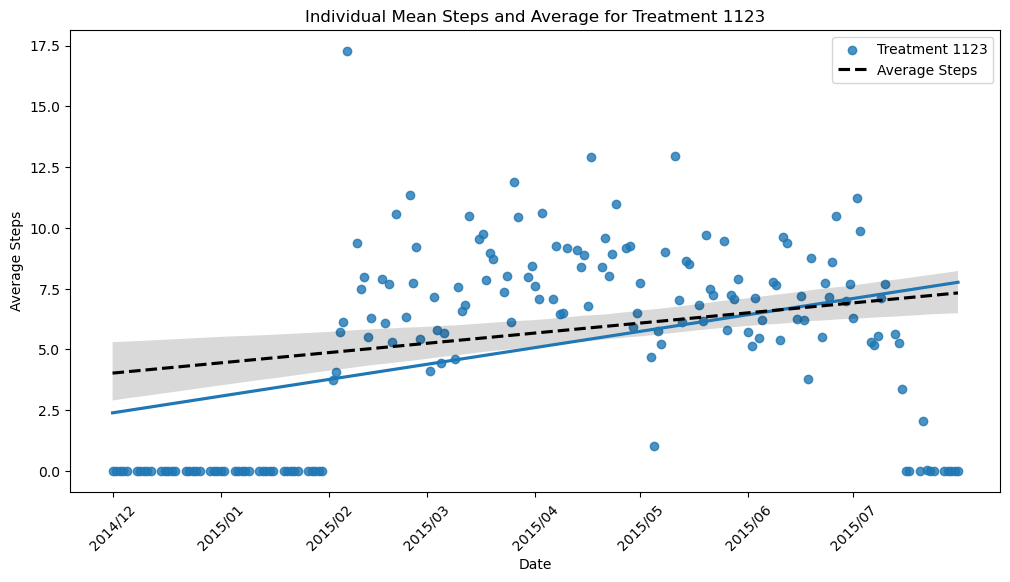

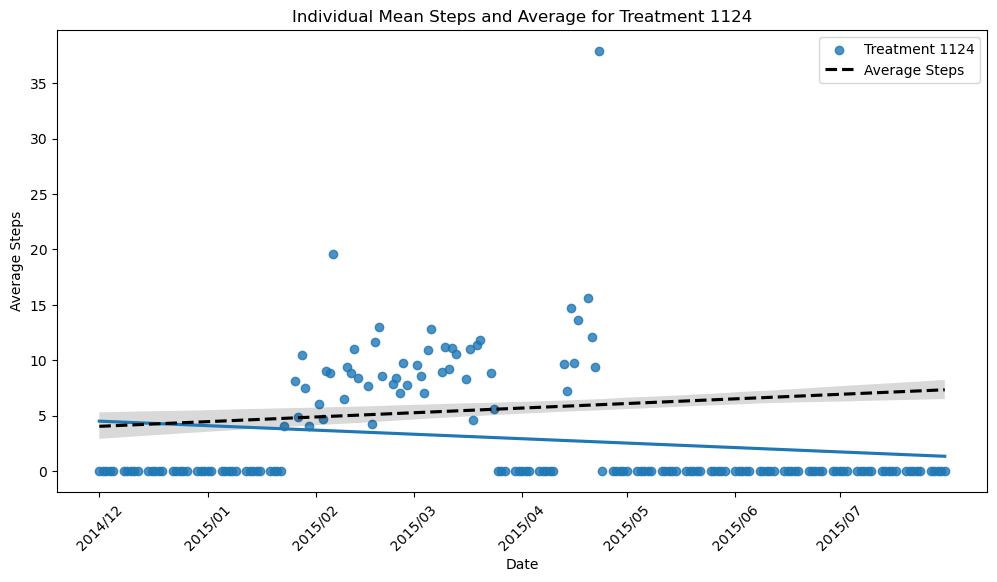

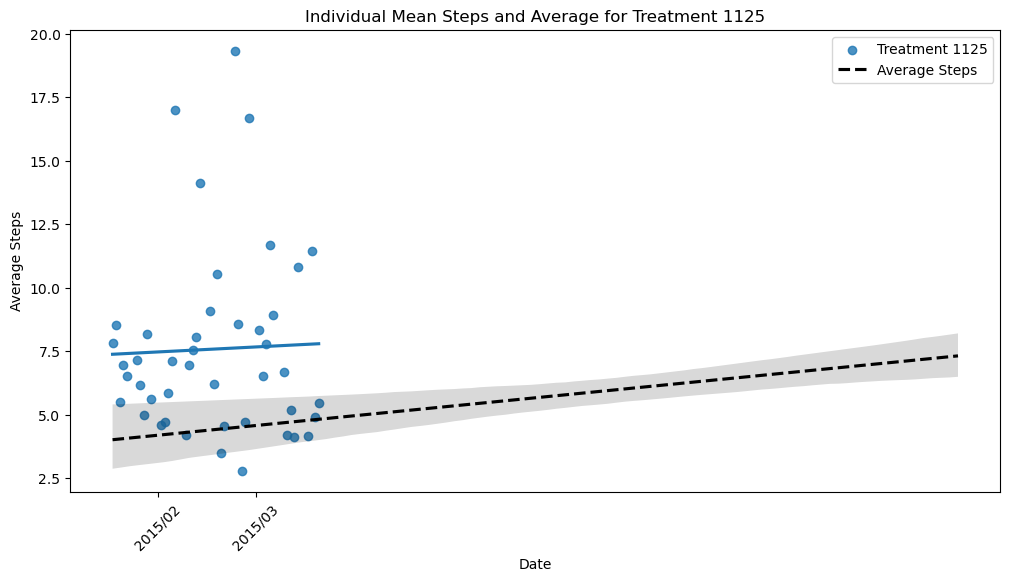

In [18]:
# Loop through all treatment_ids for individual plots
for treatment in treatment_ids:
    plt.figure(figsize=(12, 6))

    # Filter data for the current treatment_id
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()  # Use .copy() here

    # Convert 'date' to numeric for regression (safe modification)
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days

    # Plot regression for this individual
    sns.regplot(data=subset, x='date_numeric', y='steps', scatter=True, ci=None, label=f'Treatment {treatment}')

    # Plot the average steps for all individuals (same as Plot 2)
    sns.regplot(data=average_steps, x='date_numeric', y='steps', scatter=False, color='black', label='Average Steps', line_kws={'color': 'black', 'linestyle': '--'})

    # Set the x-ticks to the first day of each month (same as Plot 2)
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')  # First day of each month
    month_numeric = (months - subset['date'].min()).days  # Convert the months to numeric

    # Apply the same x-tick formatting as in Plot 2 (YYYY/MM format)
    plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)  # Format x-ticks as YYYY/MM and rotate for better readability

    # Formatting
    plt.title(f"Individual Mean Steps and Average for Treatment {treatment}")
    plt.xlabel("Date")
    plt.ylabel("Average Steps")
    plt.legend()
    plt.show()

### Plot 6: Superposed individuals and average steps

In [19]:
# Define a list of colors manually (you peux ajouter plus si nécessaire)
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [20]:
# Make sure there are enough colors for the number of treatment IDs
if len(treatment_ids) > len(treatment_colors):
    raise ValueError("Not enough colors for the number of treatment IDs!")

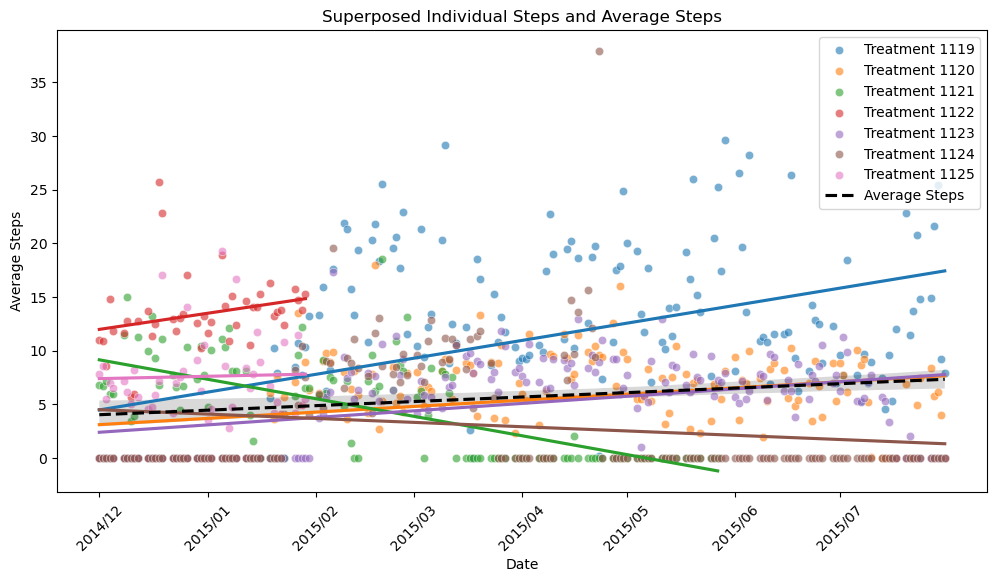

In [21]:
plt.figure(figsize=(12, 6))

# Loop through each treatment_id and plot individuals' data
for i, treatment in enumerate(treatment_ids):
    subset = individual_means[individual_means['treatment_id'] == treatment].copy()
    subset.loc[:, 'date_numeric'] = (subset['date'] - subset['date'].min()).dt.days

    # Scatter plot for each individual with unique color
    sns.scatterplot(data=subset, x='date_numeric', y='steps', alpha=0.6, color=treatment_colors[i], label=f'Treatment {treatment}')

    # Regression line for this treatment group
    sns.regplot(data=subset, x='date_numeric', y='steps', scatter=False, ci=None, color=treatment_colors[i])

# Plot the average steps for all individuals (in black, dashed)
sns.regplot(data=average_steps, x='date_numeric', y='steps', scatter=False, color='black', 
            label='Average Steps', line_kws={'color': 'black', 'linestyle': '--'})

# Set the x-ticks to the first day of each month
months = pd.date_range(start=average_steps['date'].min(), end=average_steps['date'].max(), freq='MS')
month_numeric = (months - average_steps['date'].min()).days

plt.xticks(month_numeric, months.strftime('%Y/%m'), rotation=45)
plt.title("Superposed Individual Steps and Average Steps")
plt.xlabel("Date")
plt.ylabel("Average Steps")
plt.legend()
plt.show()


### Plot 7: Correlation matrix

In [22]:
# Keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

In [23]:
# Compute correlation matrix
corr = df_numeric.corr()

In [24]:
# Remove columns that contain only NaN values
corr = corr.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [25]:
# Define a threshold for correlation values
threshold = 0.1

In [26]:
# Create a mask excluding the diagonal
mask = (corr.abs() < threshold).sum(axis=0) == (corr.shape[0] - 1)

In [27]:
# Get columns where all correlations (except diagonal) are below the threshold
low_correlation_cols = corr.columns[mask]

In [28]:
# Drop these columns and rows from the correlation matrix
corr = corr.drop(columns=low_correlation_cols, index=low_correlation_cols)

In [29]:
# Print correlation matrix as a table
print("Correlation Matrix:")
print(corr)

Correlation Matrix:
              treatment_id  fitbit_id  calories      mets     level     steps  \
treatment_id      1.000000   0.494536 -0.086128 -0.079460 -0.062669 -0.082287   
fitbit_id         0.494536   1.000000 -0.112657 -0.072801 -0.067629 -0.059734   
calories         -0.086128  -0.112657  1.000000  0.979686  0.932253  0.952129   
mets             -0.079460  -0.072801  0.979686  1.000000  0.956063  0.965284   
level            -0.062669  -0.067629  0.932253  0.956063  1.000000  0.906922   
steps            -0.082287  -0.059734  0.952129  0.965284  0.906922  1.000000   
distance         -0.074817  -0.059446  0.954111  0.964491  0.904313  0.998532   

              distance  
treatment_id -0.074817  
fitbit_id    -0.059446  
calories      0.954111  
mets          0.964491  
level         0.904313  
steps         0.998532  
distance      1.000000  


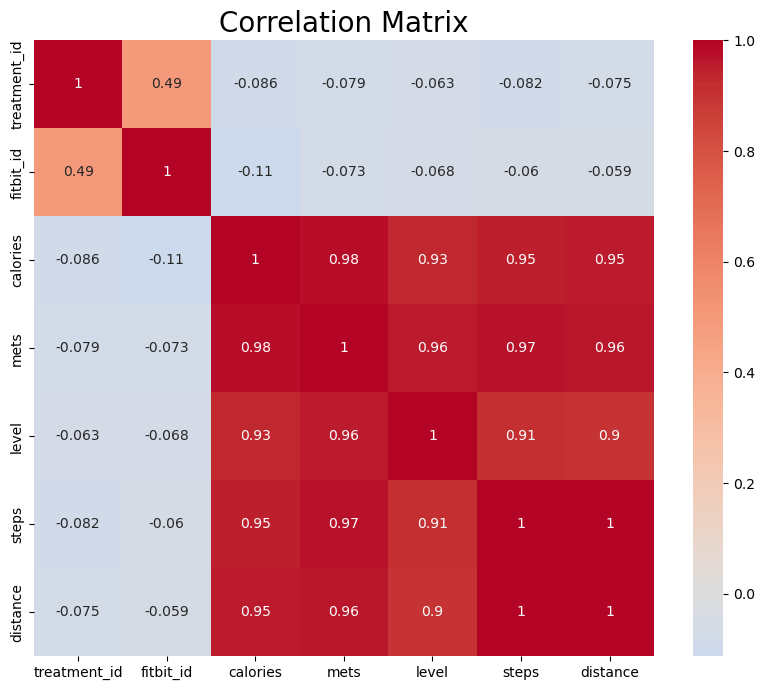

In [30]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix", fontsize=20)
plt.show()

### Plot 8: DAG graph

In [31]:
# Initialize a directed graph
dag = nx.DiGraph()

In [32]:
# Add nodes (dag_features)
dag_features = ['date', 'working_days', 'calories', 'mets', 'level', 'steps', 'distance', 'season']
dag.add_nodes_from(dag_features)

In [33]:
# Define the relationships based on correlation analysis
edges = [
    ('date', 'working_days'),
    ('date', 'season'),
    ('working_days', 'steps'),
    ('season', 'steps'),
    ('steps', 'calories'),
    ('steps', 'mets'),
    ('steps', 'level'),
    ('steps', 'distance'),
]

dag.add_edges_from(edges)

In [34]:
# Define custom positions for some nodes
pos = {
    'date': (0, 1),            # Position en haut pour 'date'
    'working_days': (-1, 0),   # Position à gauche pour 'working_days'
    'calories': (-1, -1),        # 'calories' au centre
    'mets': (0, -1),            # 'mets' à droite de 'calories'
    'season': (1, 0),          # 'level' en dessous de 'calories'
    'steps': (0, 0),          # 'steps' en dessous de 'mets'
    'distance': (-1, -2),        # 'distance' en bas de 'level'
    'level': (1, -2)        # 'distance' en bas de 'level'
}

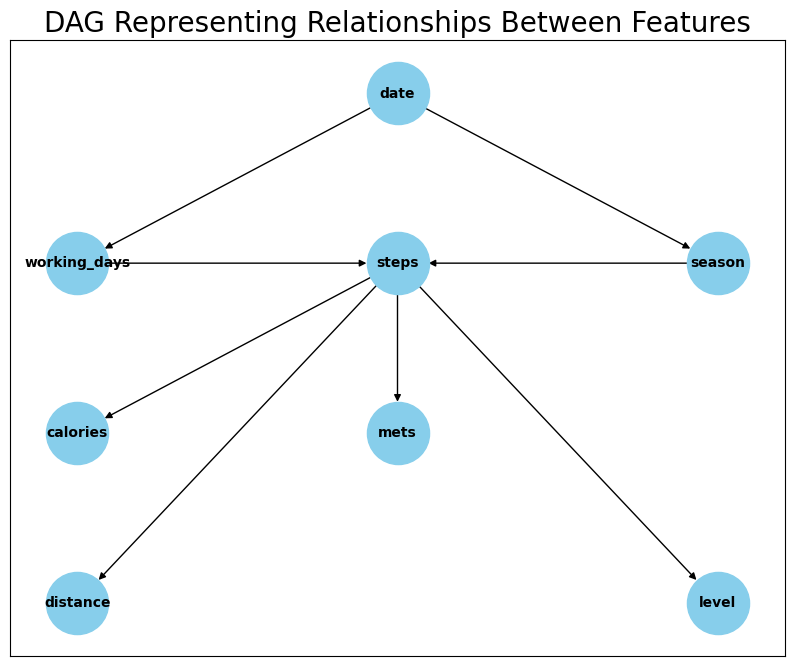

In [35]:
# Visualize the DAG with custom positions
plt.figure(figsize=(10, 8))
nx.draw_networkx(dag, pos, with_labels=True, node_size=2000, node_color="skyblue",
                font_size=10, font_weight='bold', edge_color='black')
plt.title("DAG Representing Relationships Between Features", fontsize=20)
plt.show()

## Step 2: Build a first version of the model

In [37]:
# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = df.groupby('treatment_id')['steps'].mean()

In [38]:
print("Average number of steps per person at 18:00 on a working day:")
print(average_steps_per_person)

Average number of steps per person at 18:00 on a working day:
treatment_id
1119    10.944042
1120     5.377593
1121     4.003055
1122    13.392677
1123     5.074360
1124     2.904963
1125     7.591098
Name: steps, dtype: float64


In [39]:
# Add 'season' feature
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [40]:
df['season'] = df['date'].apply(get_season)

In [41]:
# Add 'is_holiday' feature (assuming you have a list of holidays)
holidays = ['2023-01-01', '2023-12-25']  # Example list of holidays
df['is_holiday'] = df['date'].dt.strftime('%Y-%m-%d').isin(holidays)

In [42]:
# Add 'day_of_week' feature
df['day_of_week'] = df['date'].dt.weekday

In [44]:
# Add 'target' feature: whether the person reached their average steps
df['target'] = df.apply(lambda row: 1 if row['steps'] >= average_steps_per_person[row['treatment_id']] else 0, axis=1)

In [45]:
# Check the distribution of the target variable
print("\nDistribution of the target variable:")
print(df['target'].value_counts())


Distribution of the target variable:
target
0    863628
1    125652
Name: count, dtype: int64


In [46]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['season', 'day_of_week'], drop_first=False)

In [47]:
# Ensure all expected columns are present
expected_season_columns = ['season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']
expected_day_columns = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']

In [48]:
for col in expected_season_columns:
    if col not in df.columns:
        df[col] = 0

In [49]:
for col in expected_day_columns:
    if col not in df.columns:
        df[col] = 0

In [50]:
# Define features and target
features = ['calories', 'mets', 'level', 'distance', 'is_holiday'] + expected_season_columns + expected_day_columns

In [51]:
# Sort users by average steps (ascending)
sorted_users = average_steps_per_person.sort_values().index.tolist()  # Lowest to highest

In [52]:
# Find the median user
median_index = len(sorted_users) // 2

In [53]:
# Initialize variables
train_users = []  # Start with the median user
accuracy = 0
min_accuracy = 0.7
i = 1  # Start expanding from the median
direction = 1  # 1 for higher steps, -1 for lower steps

In [54]:
# Dynamically select training users until accuracy >= 0.7
while accuracy < min_accuracy and i < len(sorted_users):
    # Alternate between adding a higher-step user and a lower-step user
    if direction == 1 and median_index + i < len(sorted_users):
        train_users.append(sorted_users[median_index + i])  # Higher steps
    elif direction == -1 and median_index - i >= 0:
        train_users.append(sorted_users[median_index - i])  # Lower steps
    
    # Switch direction for the next iteration
    direction *= -1
    
    # Filter data for training and testing
    train_data = df[df['treatment_id'].isin(train_users)]
    test_data = df[~df['treatment_id'].isin(train_users)]
    
    # Prepare features and target for training and testing
    X_train = train_data[features]
    y_train = train_data['target']

    X_test = test_data[features]
    y_test = test_data['target']
    
    # Handle imbalanced data using SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nTraining users: {train_users}")
    print(f"Model Accuracy on Test Set: {accuracy:.2f}")
    
    i += 1


Training users: [1125]
Model Accuracy on Test Set: 0.99


In [55]:
# Final model evaluation
print("\nFinal Model Evaluation:")
print(f"Training users: {train_users}")
print(f"Model Accuracy on Test Set: {accuracy:.2f}")


Final Model Evaluation:
Training users: [1125]
Model Accuracy on Test Set: 0.99


In [56]:
# Classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    823718
           1       0.97      0.93      0.95    118042

    accuracy                           0.99    941760
   macro avg       0.98      0.96      0.97    941760
weighted avg       0.99      0.99      0.99    941760



In [57]:
# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[820581   3137]
 [  8011 110031]]


In [58]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
distance         0.315774
mets             0.298673
calories         0.252955
level            0.131923
day_of_week_0    0.000181
season_Winter    0.000142
day_of_week_3    0.000083
season_Spring    0.000080
day_of_week_2    0.000074
day_of_week_4    0.000069
day_of_week_1    0.000046
is_holiday       0.000000
season_Summer    0.000000
season_Autumn    0.000000
dtype: float64


In [59]:
# Check the distribution of users in training and testing sets
print("\nUsers in the training set:", train_data['treatment_id'].unique())
print("Users in the test set:", test_data['treatment_id'].unique())


Users in the training set: [1125]
Users in the test set: [1119 1120 1121 1122 1123 1124]


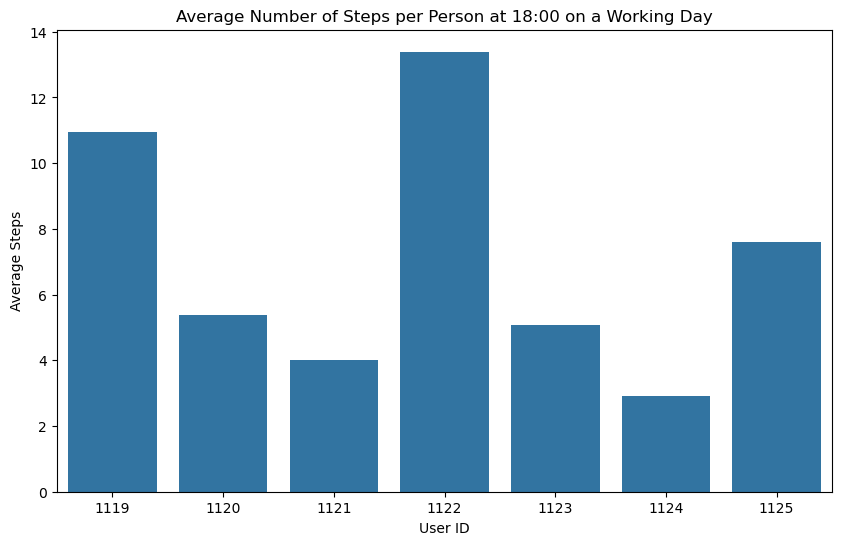

In [60]:
# Plot average steps per user
plt.figure(figsize=(10, 6))
sns.barplot(x=average_steps_per_person.index, y=average_steps_per_person.values)
plt.title("Average Number of Steps per Person at 18:00 on a Working Day")
plt.xlabel("User ID")
plt.ylabel("Average Steps")
plt.show()

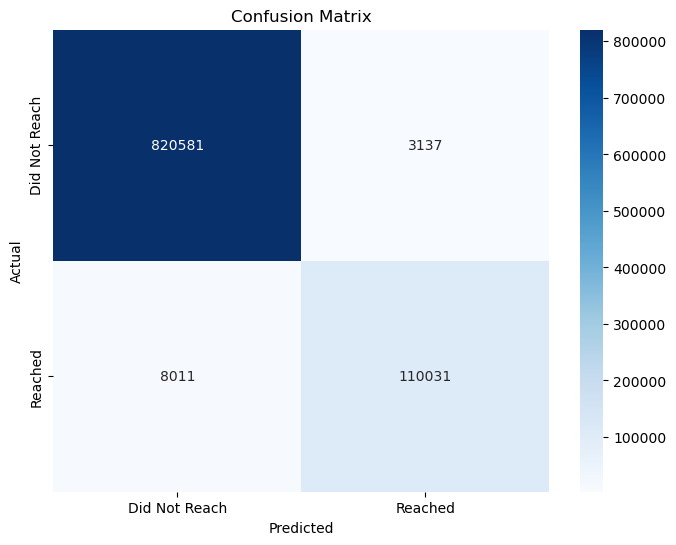

In [61]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Did Not Reach', 'Reached'], yticklabels=['Did Not Reach', 'Reached'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

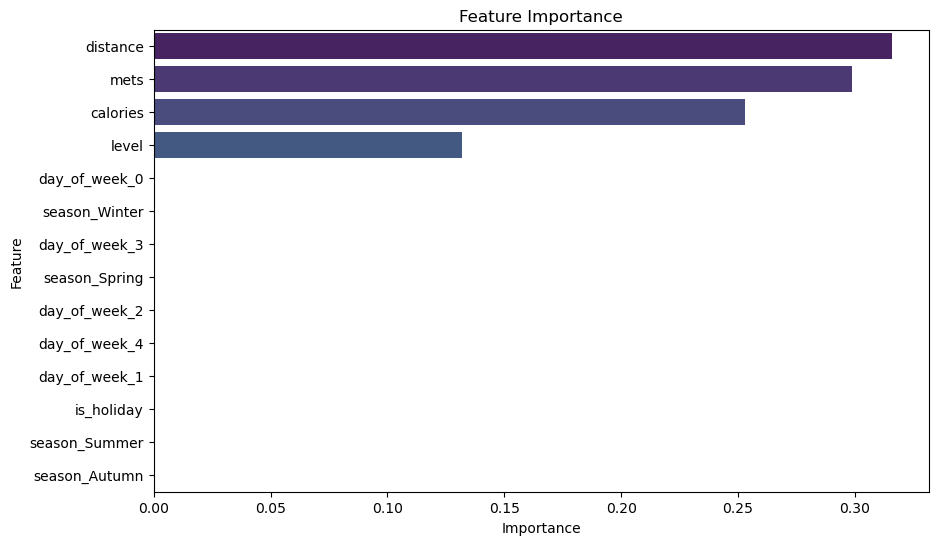

In [64]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, hue=feature_importance.index, palette='viridis', legend=False)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [67]:
# Récupérer les utilisateurs les moins et les plus actifs
first = sorted_users[-1]  # Le plus actif (dernier élément)
last = sorted_users[0]    # Le moins actif (premier élément)

In [68]:
# Summary of findings
print("\nSummary of Findings:")
print("1. The average number of steps per person at 18:00 on a working day varies significantly:")
print(f"   - Most active user: treatment n°[{first}] ({average_steps_per_person[first]:.2f} steps)")
print(f"   - Least active user: treatment n°[{last}] ({average_steps_per_person[last]:.2f} steps)")
print("2. A Random Forest model was developed to predict whether a person will reach their average steps.")
print(f"   - Model accuracy: {accuracy:.2f}")
print("   - Key features influencing predictions: distance, mets, calories, and level.")
print("   - Seasonal and day-of-week features have minimal impact.")
print("3. The model can be used to provide personalized recommendations to users based on their activity patterns.")


Summary of Findings:
1. The average number of steps per person at 18:00 on a working day varies significantly:
   - Most active user: treatment n°[1122] (13.39 steps)
   - Least active user: treatment n°[1124] (2.90 steps)
2. A Random Forest model was developed to predict whether a person will reach their average steps.
   - Model accuracy: 0.99
   - Key features influencing predictions: distance, mets, calories, and level.
   - Seasonal and day-of-week features have minimal impact.
3. The model can be used to provide personalized recommendations to users based on their activity patterns.


In [69]:
# Save results to a text file
with open("assignment_results.txt", "w") as f:
    f.write("Assignment Results:\n")
    f.write("1. Average Steps per Person:\n")
    f.write(average_steps_per_person.to_string())
    f.write("\n\n2. Model Performance:\n")
    f.write(f"Accuracy: {accuracy:.2f}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\nConfusion Matrix:\n")
    f.write(str(confusion_matrix(y_test, y_pred)))
    f.write("\n\n3. Feature Importance:\n")
    f.write(feature_importance.to_string())

In [70]:
# User input for prediction
def predict_for_user():
    print("\nPredict whether a user will reach their average steps:")
    hour = int(input("Enter the hour (0-23): "))
    day = int(input("Enter the day of the week (0=Monday, 6=Sunday): "))
    steps = float(input("Enter the current number of steps: "))
    calories = float(input("Enter the calories burned: "))
    mets = float(input("Enter the METs: "))
    level = float(input("Enter the activity level: "))
    distance = float(input("Enter the distance covered: "))
    is_holiday = int(input("Is it a holiday? (1=Yes, 0=No): "))

    # Create a DataFrame for the user input
    user_data = pd.DataFrame({
        'calories': [calories],
        'mets': [mets],
        'level': [level],
        'distance': [distance],
        'is_holiday': [is_holiday],
        'season_Spring': [0],
        'season_Summer': [0],
        'season_Autumn': [0],
        'season_Winter': [0],
        'day_of_week_0': [0],
        'day_of_week_1': [0],
        'day_of_week_2': [0],
        'day_of_week_3': [0],
        'day_of_week_4': [0]
    })

    # Set the correct season and day of the week
    user_data[f'season_{get_season(pd.to_datetime("2023-01-01"))}'] = 1  # Replace with actual date logic
    user_data[f'day_of_week_{day}'] = 1

    # Predict
    prediction = model.predict(user_data[features])
    if prediction[0] == 1:
        print("\nPrediction: The user will reach their average steps.")
    else:
        print("\nPrediction: The user will NOT reach their average steps.")

# Run the prediction function
predict_for_user()


Predict whether a user will reach their average steps:


ValueError: invalid literal for int() with base 10: ''